# Table of Contents
1. [Essential Libraries Imports](#essential-libraries-imports)
2. [Dataset Loading](#dataset-loading)
3. [Image Feature Extraction](#image-feature-extraction)
4. [Text Preprocessing](#text-preprocessing)
   - [Tokenization & Encoding](#tokenization-encoding)
5. [Prepare Data for Training](#prepare-data-for-training)
6. [Modeling](#modeling)
   - [Learning Curve Analysis](#learning-curve-analysis)
7. [Captioning Functions](#captioning-functions)


# Essential Libraries Imports


In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Reshape, concatenate, add, Bidirectional, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam

# Dataset Loading


In [2]:
image_path = '../input/Images'
df = pd.read_csv("../input/captions.txt")
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# Image Feature Extraction


In [3]:
model = DenseNet201()
fe_model = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}

# Extract features from images
for img_name in tqdm(df['image'].unique()):
    img = load_img(os.path.join(image_path, img_name), target_size=(img_size, img_size))
    img = np.expand_dims(img_to_array(img) / 255.0, axis=0)
    features[img_name] = fe_model.predict(img, verbose=0)

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 8091/8091 [12:09<00:00, 11.09it/s]


In [4]:
# Saving the features dictionary
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

# Text Preprocessing


In [ ]:
def clean_captions(df):
    df['caption'] = df['caption'].str.lower().str.replace(r"[^a-z\s]", "", regex=True)
    df['caption'] = df['caption'].str.replace(r"\s+", " ", regex=True).str.strip()
    df['caption'] = df['caption'].apply(lambda x: " ".join([w for w in x.split() if len(w) > 1]))
    df['caption'] = "startseq " + df['caption'] + " endseq"
    return df

data = clean_captions(df)
captions = data['caption'].tolist()

captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Tokenization & Encoding


In [6]:
# Tokenizing captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(caption.split()) for caption in captions)

# Train-test split
image_list = df['image'].unique().tolist()
train_size = int(0.85 * len(image_list))

train_images, val_images = image_list[:train_size], image_list[train_size:]

train_df = df[df['image'].isin(train_images)].reset_index(drop=True)
val_df = df[df['image'].isin(val_images)].reset_index(drop=True)

# Sample caption to sequence conversion
tokenizer.texts_to_sequences([captions[1], captions[2]])


[[1, 18, 312, 63, 192, 116, 2], [1, 39, 18, 118, 63, 192, 2422, 2]]

In [7]:
# Saving the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Prepare Data for Training


In [ ]:
max_length = max(len(caption.split()) for caption in captions)

class DataGenerator(Sequence):

    def __init__(self, df, image_col, caption_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):

        self.df = df.copy()
        self.image_col = image_col
        self.caption_col = caption_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.image_col].tolist()

        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.image_col] == image, self.caption_col].tolist()

            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        return np.array(X1), np.array(X2), np.array(y)

# Training and Validation Data Generators
train_gen = DataGenerator(
    df=train_df,
    image_col='image',
    caption_col='caption',
    batch_size=64,
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
)

val_gen = DataGenerator(
    df=val_df,
    image_col='image',
    caption_col='caption',
    batch_size=64,
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
)

train_gen[0]
val_gen[0]


((array([[1.25011822e-04, 5.09152655e-04, 1.84615154e-03, ...,
          4.90259439e-01, 3.22616428e-01, 3.16555891e-03],
         [1.25011822e-04, 5.09152655e-04, 1.84615154e-03, ...,
          4.90259439e-01, 3.22616428e-01, 3.16555891e-03],
         [1.25011822e-04, 5.09152655e-04, 1.84615154e-03, ...,
          4.90259439e-01, 3.22616428e-01, 3.16555891e-03],
         ...,
         [1.20480734e-04, 7.18614087e-04, 2.08272017e-03, ...,
          4.15950492e-02, 1.20721832e-01, 2.59054918e-02],
         [1.20480734e-04, 7.18614087e-04, 2.08272017e-03, ...,
          4.15950492e-02, 1.20721832e-01, 2.59054918e-02],
         [1.20480734e-04, 7.18614087e-04, 2.08272017e-03, ...,
          4.15950492e-02, 1.20721832e-01, 2.59054918e-02]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1, 260],
         [  0,   0,   0, ...,   1, 260,  18],
         ...,
         [  0,   0,   0, ...,   9, 175,   3],
         [  0,   0,   0, ..., 175,   3,

# Modeling


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Reshape, concatenate, add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# Model architecture
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

# Image feature processing
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256))(img_features)

# Caption feature processing
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# Merging image and caption features
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

# Adding Dropout and Skip Connection
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])

# Dense layers and final output
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

# Compiling the model
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Model checkpoint and callbacks
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=1e-8)

# Training the model
history = caption_model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - loss: 5.6697
Epoch 1: val_loss improved from inf to 4.18337, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 307s 557ms/step - loss: 5.6685 - val_loss: 4.1834 - learning_rate: 0.0010
Epoch 2/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 4.2129
Epoch 2: val_loss improved from 4.18337 to 3.90087, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step - loss: 4.2127 - val_loss: 3.9009 - learning_rate: 0.0010
Epoch 3/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 3.9240
Epoch 3: val_loss improved from 3.90087 to 3.76413, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 80s 147ms/step - loss: 3.9239 - val_loss: 3.7641 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 3.7648
Epoch 4: val_loss improved from 3.76413 to 3.70405, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 81s 149ms/step - loss: 3.7648 - val_loss: 3.7040 - learning_rate: 0.0010
Epoch 5/50

## Learning Curve Analysis

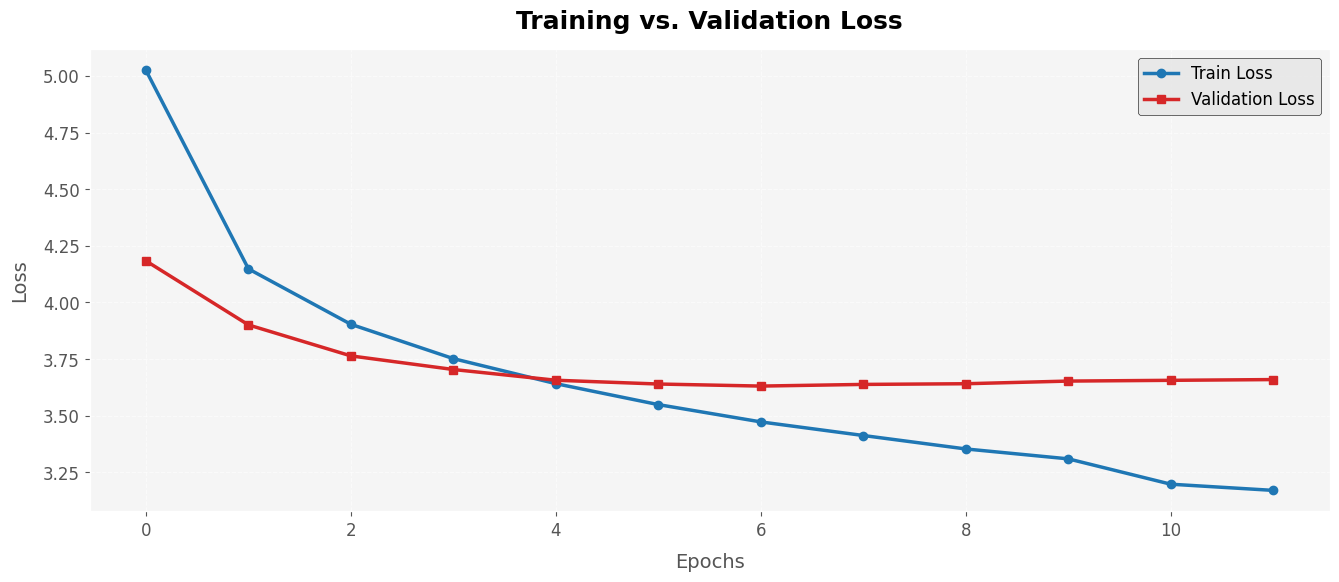

In [10]:
plt.style.use('ggplot')

plt.figure(figsize=(16, 6), dpi=100)

plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linewidth=2.5, marker='o', markersize=6)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#d62728', linewidth=2.5, marker='s', markersize=6)

plt.title('Training vs. Validation Loss', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Epochs', fontsize=14, labelpad=10)
plt.ylabel('Loss', fontsize=14, labelpad=10)

plt.legend(loc='upper right', fontsize=12, frameon=True, edgecolor='black')

plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.gca().set_facecolor('#f5f5f5')

plt.show()


# Captioning Functions


In [ ]:
# Loading save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
features_path = "features.pkl"

def generate_and_display_caption(image_path, model_path, tokenizer_path, features_path, max_length=34, img_size=224):
    caption_model = load_model(model_path)

    with open(features_path, "rb") as f:
        features = pickle.load(f)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocessing the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    # Extracting image features
    img_name = image_path.split("/")[-1]  
    image_features = features.get(img_name, None)

    if image_features is None:
        print(f"Error: No features found for {img_name}.")
        return

    # Generating the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='black', verticalalignment='bottom', horizontalalignment='center')

    plt.subplots_adjust(bottom=0.1)
    plt.show()


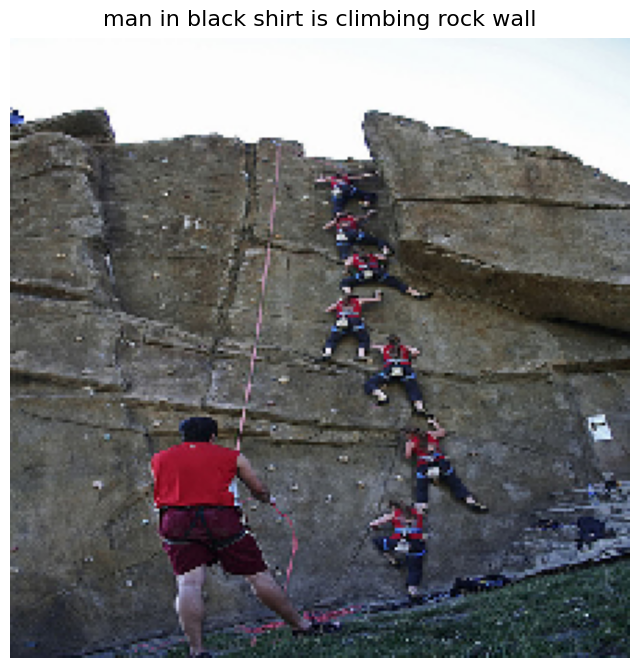

In [ ]:
image_path = "../input/Images/1016887272_03199f49c4.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, features_path)

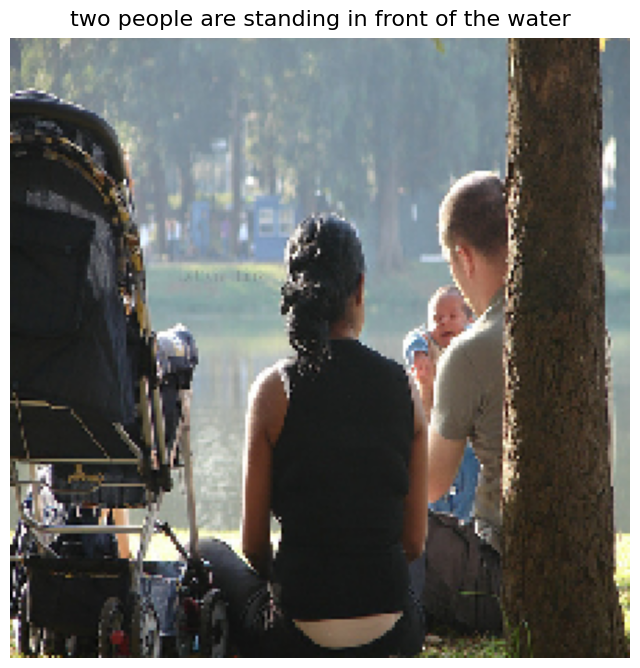

In [ ]:
image_path = "../input/Images/1022454428_b6b660a67b.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, features_path)

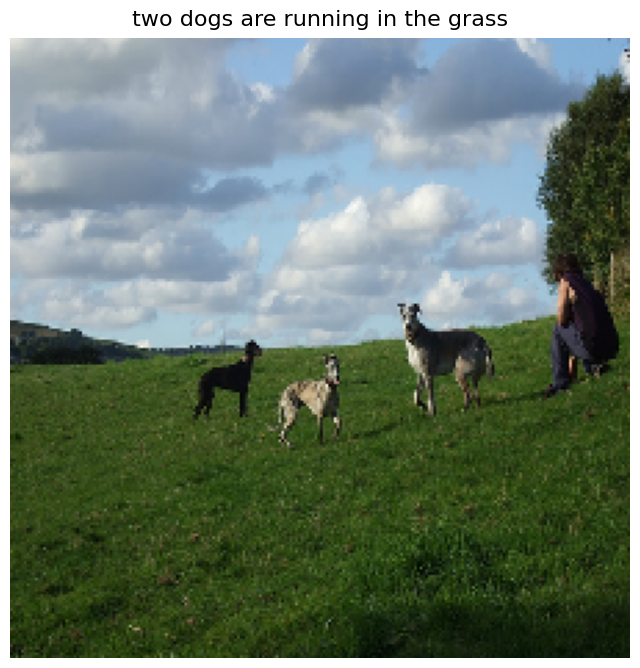

In [ ]:
image_path = "../input/Images/1032122270_ea6f0beedb.jpg"
generate_and_display_caption(image_path, model_path, tokenizer_path, features_path)